In [ ]:
import allel  # type: ignore
import dask
import numba  # type: ignore
import numpy as np
import pandas as pd
import plotly.express as px  # type: ignore
import plotly.graph_objects as go  # type: ignore
import xarray as xr
import sgkit as sg

df_samples = pd.read_csv('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata_qcpass.20240914.csv')

analysis_popcols =  {'saudi_e': '#6a3d9a',
'saudi_r': '#cab2d6',
'india_m': '#a6cee3',
 'india_b': '#1f78b4',
 'afgh_pak': '#ff7f00',
 'djibouti': '#e31a1c',
 'ethiopia_n': '#33a02c',
 'ethiopia_so': '#b2df8a',
 'yemen': '#fdbf6f',
 'sudan': '#fb9a99'}


In [12]:
#define stevegen1000 functions
def select_random_genos(
                    ds, 
                    numgenos=100_000):
                     #selects given number of genos at random
                    keep_indices = np.random.choice(ds.call_genotype.shape[0], numgenos, replace=False)
                    keep_indices.sort()
                    thinned_callset = ds.isel(variants=~keep_indices)
                    return(thinned_callset)

def load_geno_ds(chrom, 
                sample_query=None, 
                numgenos=None, 
                sample_list=None, 
                start=None, 
                end=None, 
                min_minor_ac=None,
                df_samples=df_samples):
                 # load sample metadata
     #load ds
     ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.CM023248.zarr')

     if sample_query:
          # locate selected samples
          loc_samples = df_samples.eval(sample_query).values
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     elif sample_list:
          loc_samples = df_samples['sample_id'].isin(sample_list)
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     else:
          pass
          
     #if numgenos is set, subset 
     if numgenos:
          ds_analysis = select_random_genos(ds)
     else:
          ds_analysis = ds

     #if region is set, subset to region
     if start:
               #subset to region of interest
              print(f"subsetting haps to range {chrom}:{start}-{end}")
              ds_analysis = ds_analysis.set_index(variants=("variant_contig", "variant_position")).sel(variants=(0, slice(start,end)))
     else:
            pass
     
     #if minmaf is specified, select minmaf  
     if min_minor_ac:   
        print(f'subsetting to segregating sites')
        ac = allel.GenotypeArray(ds_analysis['call_genotype']).count_alleles()
        macbool = ac[:,1] >= min_minor_ac
        print(f'selected {np.sum(macbool)} sites with a min mac > {min_minor_ac}')
        ds_analysis = ds_analysis.sel(variants=(macbool))

     #get accessible only
     print('subsetting to accessible sites only')
     accmask = ds_analysis['is_accessible'].compute()
     ds_analysis = ds_analysis.sel(variants=(accmask))

     #return completed ds
     return(df_samples, ds_analysis)

def jackknife_ci(stat_data, jack_stat, confidence_level):
    """Compute a confidence interval from jackknife resampling.

    Parameters
    ----------
    stat_data : scalar
        Value of the statistic computed on all data.
    jack_stat : ndarray
        Values of the statistic computed for each jackknife resample.
    confidence_level : float
        Desired confidence level (e.g., 0.95).

    Returns
    -------
    estimate
        Bias-corrected "jackknifed estimate".
    bias
        Jackknife bias.
    std_err
        Standard error.
    ci_err
        Size of the confidence interval.
    ci_low
        Lower limit of confidence interval.
    ci_upp
        Upper limit of confidence interval.

    Notes
    -----
    N.B., this implementation is based on code from astropy, see:

    https://github.com/astropy/astropy/blob/8aba9632597e6bb489488109222bf2feff5835a6/astropy/stats/jackknife.py#L55

    """
    from scipy.special import erfinv  # type: ignore

    n = len(jack_stat)

    mean_jack_stat = np.mean(jack_stat)

    # jackknife bias
    bias = (n - 1) * (mean_jack_stat - stat_data)

    # jackknife standard error
    std_err = np.sqrt(
        (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))
    )

    # bias-corrected "jackknifed estimate"
    estimate = stat_data - bias

    # confidence interval
    z_score = np.sqrt(2.0) * erfinv(confidence_level)
    ci_err = 2 * z_score * std_err
    ci_low, ci_upp = estimate + z_score * np.array((-std_err, std_err))

    return estimate, bias, std_err, ci_err, ci_low, ci_upp

def block_jackknife_cohort_diversity_stats(
    cohort_label, ac, n_jack, confidence_level, chromlen
    ):

        n_sites = ac.shape[0]
        ac = allel.AlleleCountsArray(ac)
        n = ac.sum(axis=1).max()  # number of chromosomes sampled
        n_sites = min(n_sites, ac.shape[0])  # number of sites
        block_length = n_sites // n_jack  # number of sites in each block
        n_sites_j = n_sites - block_length  # number of sites in each jackknife resample

        a1 = np.sum(1 / np.arange(1, n))
        a2 = np.sum(1 / (np.arange(1, n) ** 2))
        b1 = (n + 1) / (3 * (n - 1))
        b2 = 2 * (n**2 + n + 3) / (9 * n * (n - 1))
        c1 = b1 - (1 / a1)
        c2 = b2 - ((n + 2) / (a1 * n)) + (a2 / (a1**2))
        e1 = c1 / a1
        e2 = c2 / (a1**2 + a2)

        mpd_data = allel.mean_pairwise_difference(ac, fill=0)
        # N.B., here we compute the number of segregating sites as the number
        # of alleles minus 1. This follows the sgkit and tskit implementations,
        # and is different from scikit-allel.
        seg_data = ac.allelism() - 1

        theta_pi_abs_data = np.sum(mpd_data)
        theta_pi_data = theta_pi_abs_data / chromlen
        S_data = np.sum(seg_data)
        theta_w_abs_data = S_data / a1
        theta_w_data = theta_w_abs_data / n_sites
        d_data = theta_pi_abs_data - theta_w_abs_data
        d_stdev_data = np.sqrt((e1 * S_data) + (e2 * S_data * (S_data - 1)))
        tajima_d_data = d_data / d_stdev_data

        jack_theta_pi = []
        jack_theta_w = []
        jack_tajima_d = []

        for i in range(n_jack):
            # locate block to delete
            block_start = i * block_length
            block_stop = block_start + block_length
            loc_j = np.ones(n_sites, dtype=bool)
            loc_j[block_start:block_stop] = False
            assert np.count_nonzero(loc_j) == n_sites_j

            # resample data and compute statistics

            # theta_pi
            mpd_j = mpd_data[loc_j]
            theta_pi_abs_j = np.sum(mpd_j)
            theta_pi_j = theta_pi_abs_j / n_sites_j
            jack_theta_pi.append(theta_pi_j)

            # theta_w
            seg_j = seg_data[loc_j]
            S_j = np.sum(seg_j)
            theta_w_abs_j = S_j / a1
            theta_w_j = theta_w_abs_j / n_sites_j
            jack_theta_w.append(theta_w_j)

            # tajima_d
            d_j = theta_pi_abs_j - theta_w_abs_j
            d_stdev_j = np.sqrt((e1 * S_j) + (e2 * S_j * (S_j - 1)))
            tajima_d_j = d_j / d_stdev_j
            jack_tajima_d.append(tajima_d_j)

        # calculate jackknife stats
        (
            theta_pi_estimate,
            theta_pi_bias,
            theta_pi_std_err,
            theta_pi_ci_err,
            theta_pi_ci_low,
            theta_pi_ci_upp,
        ) = jackknife_ci(
            stat_data=theta_pi_data,
            jack_stat=jack_theta_pi,
            confidence_level=confidence_level,
        )
        (
            theta_w_estimate,
            theta_w_bias,
            theta_w_std_err,
            theta_w_ci_err,
            theta_w_ci_low,
            theta_w_ci_upp,
        ) = jackknife_ci(
            stat_data=theta_w_data,
            jack_stat=jack_theta_w,
            confidence_level=confidence_level,
        )
        (
            tajima_d_estimate,
            tajima_d_bias,
            tajima_d_std_err,
            tajima_d_ci_err,
            tajima_d_ci_low,
            tajima_d_ci_upp,
        ) = jackknife_ci(
            stat_data=tajima_d_data,
            jack_stat=jack_tajima_d,
            confidence_level=confidence_level,
        )

        return dict(
            cohort=cohort_label,
            theta_pi=theta_pi_data,
            theta_pi_estimate=theta_pi_estimate,
            theta_pi_bias=theta_pi_bias,
            theta_pi_std_err=theta_pi_std_err,
            theta_pi_ci_err=theta_pi_ci_err,
            theta_pi_ci_low=theta_pi_ci_low,
            theta_pi_ci_upp=theta_pi_ci_upp,
            theta_w=theta_w_data,
            theta_w_estimate=theta_w_estimate,
            theta_w_bias=theta_w_bias,
            theta_w_std_err=theta_w_std_err,
            theta_w_ci_err=theta_w_ci_err,
            theta_w_ci_low=theta_w_ci_low,
            theta_w_ci_upp=theta_w_ci_upp,
            tajima_d=tajima_d_data,
            tajima_d_estimate=tajima_d_estimate,
            tajima_d_bias=tajima_d_bias,
            tajima_d_std_err=tajima_d_std_err,
            tajima_d_ci_err=tajima_d_ci_err,
            tajima_d_ci_low=tajima_d_ci_low,
            tajima_d_ci_upp=tajima_d_ci_upp,
        )
def cohort_diversity_stats(
        chrom,
        chromlen,
        sample_query,
        cohort_label,
        random_seed = 42,
        n_jack= 200,
        confidence_level = 0.95,
    ):
    

        #load ds
        df_samples, ds = load_geno_ds(chrom=chrom,
                     sample_query=sample_query,
                     )
        print('loaded ds')
        ac = allel.GenotypeArray(ds['call_genotype'].compute()).count_alleles()

        stats = block_jackknife_cohort_diversity_stats(
            cohort_label=cohort_label,
            chromlen=chromlen,
            ac=ac,
            n_jack=n_jack,
            confidence_level=confidence_level,
        )

        extra_fields = [
            ("location", "unique"),
            ("country", "unique"),
            ("longitude", "mean"),
            ("latitude", "mean"),
        ]
        for field, agg in extra_fields:
            if agg == "unique":
                vals = df_samples[field].dropna().sort_values().unique()
                if len(vals) == 0:
                    val = np.nan
                elif len(vals) == 1:
                    val = vals[0]
                else:
                    val = vals.tolist()
            elif agg == "mean":
                vals = df_samples[field].dropna()
                if len(vals) == 0:
                    val = np.nan
                else:
                    val = np.mean(vals)
            else:
                val = np.nan
            stats[field] = val

        return pd.Series(stats)

def diversity_stats(
    chrom,
    chromlen,
    sample_query,
    cohort_label,
    random_seed = 42,
    n_jack= 200,
    confidence_level =  0.95,
):

    # Compute diversity stats for cohorts.
    stats = cohort_diversity_stats(
        chrom,
        chromlen,
        sample_query,
        cohort_label, 
        random_seed=random_seed,
        n_jack=n_jack,
        confidence_level=confidence_level
    )
    df_stats = pd.DataFrame(stats)

    return df_stats

In [13]:
dflist = []
for pop in df_samples.pop_code.unique():
    thetdf = diversity_stats(chrom='CM023248',
                             chromlen=93706023,
                    sample_query=f'pop_code == "{pop}"',
                    cohort_label=pop)
    dflist.append(thetdf)

subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds


In [27]:
pidf = pd.concat(dflist, axis=1)

#palettes
pop_code_cols = {
    'APA' : '#ff7f00', #orange
    'SAE' : '#6a3d9a', #dark purple
    'SAR' : '#cab2d6', #ligher purple
    'IRN' : '#C2907A', #not sure yet
    'INB' : '#96172e', #darkred
    'INM' : '#f03e5e', #lightred
    'DJI' : '#507d2a', #sap green
    'ETC' : '#007272', #cobalt turq
    'ETS' : '#33a02c',#green
    'ETW' : '#a6cee3',#cerulean
    'SUD' : '#fccf86',#ochre
    'YEM' : '#CC7722'#pinkish
}

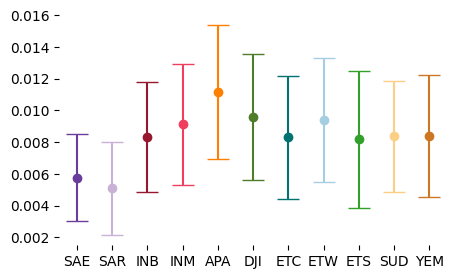

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Extract rows for the data
population_labels = pidf.iloc[0]  # Row 0: population labels
theta_pi = pidf.iloc[1].tolist()         # Row 1: theta_pi values
ci = pidf.iloc[5].tolist()                 # Row 5: ci (confidence interval) values


pops_ordered = ['SAE','SAR','INB','INM','APA','DJI','ETC','ETW','ETS','SUD','YEM']

pidf.columns = pidf.iloc[0]

# Create the plot
plt.figure(figsize=(5, 3))

for pop in pops_ordered:
    col = pidf[pop]
    pi = col.iloc[1]
    ci = col.iloc[5]
    color = pop_code_cols.get(pop, 'k')  # Get the color from dictionary, default to 'k' (black)
    plt.errorbar(x=pop, y=pi, yerr=ci, fmt='o', color=color, capsize=8)

# format plots
sns.despine(left=True, bottom=True)    
plt.savefig('/Users/dennistpw/Projects/AsGARD/figures/pi.svg')

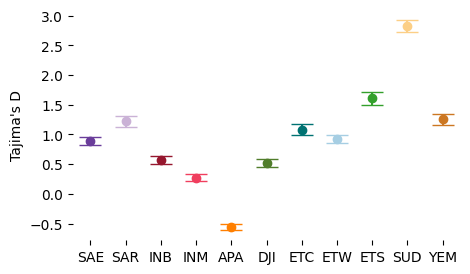

In [36]:
# Create the plot
plt.figure(figsize=(5, 3))

for pop in pops_ordered:
    col = pidf[pop]
    d = col.iloc[15]
    ci = col.iloc[19]
    color = pop_code_cols.get(pop, 'k')  # Get the color from dictionary, default to 'k' (black)
    plt.errorbar(x=pop, y=d, yerr=ci, fmt='o', color=color, capsize=8)

# format plots
sns.despine(left=True, bottom=True)    
plt.ylabel('Tajima\'s D')
plt.savefig('/Users/dennistpw/Projects/AsGARD/figures/tD.svg')
